In [147]:
# Import vizdoom for game env
from vizdoom import *
# Import radom action for sampling random actions
import random
# Import time for sleep
import time
# Import numpy for identity matrix
import numpy as np
# Import environment base class from OpenAI gym
from gym import Env
# Import gym spaces for defining the action space, Box returns a n-dim array, Discrete is a set of binary values
from gym.spaces import Discrete, Box
# Import opencv for image processing (grayscaling)
import cv2
# Import matplotlib 
from matplotlib import pyplot as plt

In [157]:
class VizDoomEnv(Env):
    # function that is called when we start env
    def __init__(self, render = False):
        # Inherit from Env
        super().__init__()
        
        self.game = DoomGame()
        self.game.load_config('ViZDoom/gtihub/ViZDoom/scenarios/basic.cfg')

        self.observation_space = Box(low =0, high = 255, shape = (100, 160, 1), dtype = np.uint8)
        self.action_space = Discrete(3)

        # render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)

        # start the game
        self.game.init()

        
    # this is how we take a step in the environment    
    def step(self, action):
        # actions = array([[1, 0, 0],
        ##                 [0, 1, 0],
        ##                 [0, 0, 1]], dtype=uint8)
        
        actions = np.identity(3, dtype = np.uint8)

        # take an action with a frameskip of 4 - frameskip is needed for AI to get feedback
        reward = self.game.make_action(actions[action], 4)

        if self.game.get_state():
            # get the screen image and game variables
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            # get the game variables like Ammo
            info = self.game.get_state().game_variables[0]
        
        # handling game end scenario when get_state and ammo are zeros
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0

        info = {"info":info}
        done = self.game.is_episode_finished()
        return state, reward, done, info

    # reset the instance 
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer            
        return self.grayscale(state)
        
 
    # grayscale the game frame and resize it 
    ## observation will be the gameframe
    def grayscale(self, observation):
        ## moveaxis will rearange the order in a way that cvtColor can accept
        ### in this instance from (3, 240, 320) to (240, 320, 3) - color channels at the end
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)

        ##cut the frame down to scale down and reduces the pixels
        resize = cv2.resize(gray, (160, 100), interpolation = cv2.INTER_CUBIC)
        state = np.reshape(resize, (100, 160, 1))
        return state
        
   # this is already defined to render but vizdoom does this for us
    def render():
        pass 
        
    def close(self):
        self.game.close()

In [131]:
env = VizDoomEnv(render = True)

In [134]:
env.close()

In [85]:
state.shape

(240, 320)

In [125]:
state = env.reset()

In [96]:
np.moveaxis(state, 0,-1).shape

(320, 240)

In [126]:
# Import Environment checker
from stable_baselines3.common import env_checker

In [133]:
env_checker.check_env(env)

# 3. View State

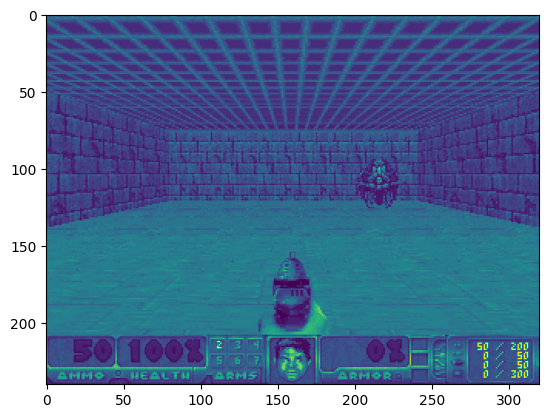

In [97]:
plt.imshow(state)

# 4. Set up CallBack

In [149]:
# Import os for file navigation
import os
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [158]:
class TrainingLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainingLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_COMPLEX{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [159]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [160]:
# Setup the call back
callback = TrainingLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# 5 Train Model

In [161]:
# Import PPO (Proximal Policy Optimization) for algorithm 
from stable_baselines3 import PPO 

In [162]:
# Non rendered environment
env = VizDoomEnv()

In [163]:
model = PPO('CnnPolicy', env, tensorboard_log = LOG_DIR, verbose = 1, learning_rate = 0.0001, n_steps = 256)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
model.learn(total_timesteps = 100000, callback = callback)

Logging to ./logs/log_basic\PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.6     |
|    ep_rew_mean     | -88.9    |
| time/              |          |
|    fps             | 26       |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 256      |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 31.7       |
|    ep_rew_mean          | -80.8      |
| time/                   |            |
|    fps                  | 18         |
|    iterations           | 2          |
|    time_elapsed         | 26         |
|    total_timesteps      | 512        |
| train/                  |            |
|    approx_kl            | 0.03514768 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | 2.12e-05   |
|    learni